### Load Data and libraries

In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import math

In [2]:
# Load data
data = read_csv(r"C:\Users\zhouq\OneDrive - Nanyang Technological University\FYP\Codes\FYP\Data_transform.csv", header = 0,  index_col=0, parse_dates=True, dayfirst=False)

# Select 3 exogenous variables 
data_new = data[['GDP', 'M1', 'M7','M12']]
data_new = data_new.dropna()
display(data_new)

# Split the data into training and testing sets
train_size = int(len(data_new) * 0.8)
train, test = data_new[:train_size], data_new[train_size:]

,GDP,M1,M7,M12
Date,,,,
1959-06-30,0.022301,0.012391,0.005828,0.196667
1959-09-30,0.000705,-0.019971,-0.002374,0.123333
1959-12-31,0.002845,0.019589,-0.008020,0.076667
1960-03-31,0.022228,0.002654,0.009733,-0.050000
1960-06-30,-0.005405,-0.007252,0.003164,-0.173333
...,...,...,...,...
2018-12-31,0.002229,-0.000848,-0.002520,0.106667
2019-03-29,0.005960,-0.003236,0.009089,0.046667
2019-06-28,0.007898,-0.001557,0.003632,-0.010000


### ARX Model

In [54]:
# Define and fit the ARX model
order = (1, 0, 0)  # AR(1)
model = ARIMA(endog=train[['GDP']], exog=train.iloc[:, 1:], order=order)
fit = model.fit(method='yule_walker')

c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BQ-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BQ-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BQ-DEC will be used.
  self._init_dates(dates, freq)


#### Fixed parameter point forecast

In [55]:
# make predictions - one step ahead forecast
forecast = fit.predict(start=len(train), end=len(data_new)-1, exog=test.iloc[:, 1:])
display(forecast)

# one step ahead forecast
# fore_1 = fit.forecast(steps=1, exog=test.iloc[0:3, 1:])

2007-12-31    0.006041
2008-03-31    0.001676
2008-06-30    0.000496
2008-09-30   -0.018602
2008-12-31   -0.013195
2009-03-31   -0.011672
2009-06-30   -0.000224
2009-09-30    0.014442
2009-12-31    0.009537
2010-03-31    0.013579
2010-06-30    0.010963
2010-09-30    0.009078
2010-12-31    0.009129
2011-03-31    0.007793
2011-06-30    0.005713
2011-09-30    0.008960
2011-12-30    0.009271
2012-03-30    0.007720
2012-06-29    0.006541
2012-09-28    0.005659
2012-12-31    0.008575
2013-03-29    0.008371
2013-06-28    0.005412
2013-09-30    0.007823
2013-12-31    0.006598
2014-03-31    0.010333
2014-06-30    0.008233
2014-09-30    0.006463
2014-12-31    0.006675
2015-03-31   -0.000361
2015-06-30    0.000866
2015-09-30    0.005036
2015-12-31   -0.000813
2016-03-31    0.002467
2016-06-30    0.007702
2016-09-30    0.004597
2016-12-30    0.006631
2017-03-31    0.005903
2017-06-30    0.008843
2017-09-29    0.004377
2017-12-29    0.011141
2018-03-30    0.007760
2018-06-29    0.008742
2018-09-28 

In [86]:
# Evaluate the model 
mse = mean_squared_error(test['GDP'], forecast)
print('MSE: '+str(mse))

mae = mean_absolute_error(test['GDP'], forecast)
print('MAE: '+str(mae))

rmse_f = math.sqrt(mean_squared_error(test['GDP'], forecast))
print('RMSE: '+str(rmse))

MSE: 2.578817302342955e-05
MAE: 0.0036854222576466287
RMSE: 0.0051197002916845095


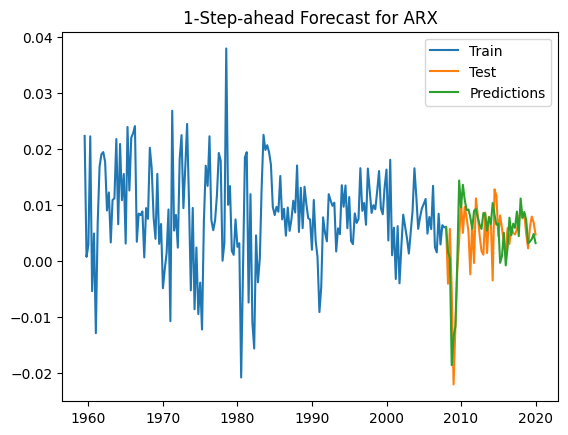

In [10]:
# Plot the actual vs. predicted values
plt.plot(data_new.index[:len(train)], train['GDP'], label='Train')
plt.plot(data_new.index[len(train):], test['GDP'], label='Test')
plt.plot(data_new.index[len(train):], forecast, label='Predictions')
plt.title("1-Step-ahead Forecast for ARX")
plt.legend()
plt.show()

#### Expanding window forecast

In [87]:
hist_exo = train.iloc[:, 1:].copy(deep=True)
hist_endo = pd.DataFrame(train['GDP'].copy(deep=True))
fore_ew = list()
 
for t in range(len(test)):
 # model set up and fit
 model = ARIMA(endog=hist_endo, exog=hist_exo, order=order)
 fit = model.fit(method='yule_walker')
 output = fit.forecast(steps=1, exog = test.iloc[t,1:])
 
 # update training dataset with observed data
 hist_exo = hist_exo._append(test.iloc[t, 1:],ignore_index=True)
 new_value = test.iloc[t,0]
 new_row = {col: new_value for col in hist_endo.columns}
 hist_endo = hist_endo._append(new_row, ignore_index=True)
 
 # add forecast value to list
 fore_ew.append(output) 
 # obs = test.iloc[t,0] # actual
 # print('predicted=%f, actual=%f' % (output, obs))
 
# evaluate forecasts
rmse_ew = math.sqrt(mean_squared_error(test['GDP'], fore_ew))
print('RMSE: '+str(rmse))



c:\Users\zhouq\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BQ-DEC will be used.
  self._init_dates(dates, freq)


RMSE: 0.0051197002916845095


In [52]:
# check if hist_endo append correctly
df1_reset = hist_endo.reset_index(drop=True)
df2_reset = data_new['GDP'].reset_index(drop=True)
equal_ignoring_index = df1_reset.equals((df2_reset).to_frame())
print(equal_ignoring_index)

True


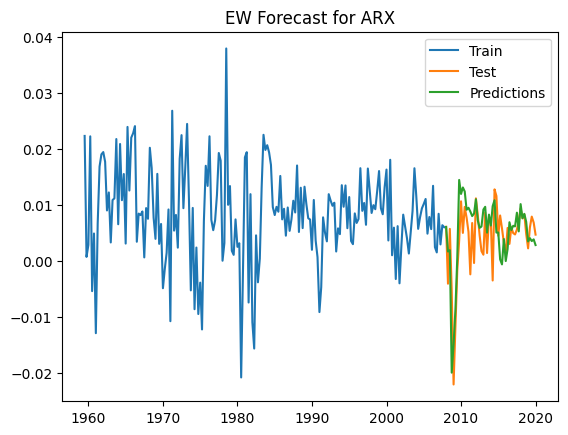

In [58]:
# plot forecasts against actual outcomes
plt.plot(data_new.index[:len(train)], train['GDP'], label='Train')
plt.plot(data_new.index[len(train):], test['GDP'], label='Test')
plt.plot(data_new.index[len(train):], fore_ew, label='Predictions')
plt.title("EW Forecast for ARX")
plt.legend()
plt.show()


#### Rolling window forecast

In [88]:
hist_exo_rw = train.iloc[:, 1:].copy(deep=True)
hist_endo_rw = pd.DataFrame(train['GDP'].copy(deep=True))

fore_rw = []

import warnings
# Ignore ValueWarning
warnings.filterwarnings("ignore")

for t in range(len(test)):
 # model set up and fit
 model = ARIMA(endog=hist_endo_rw, exog=hist_exo_rw, order=order)
 fit = model.fit(method='yule_walker')
 output = fit.forecast(steps=1, exog = test.iloc[t,1:])
 
 # update training dataset with observed data
 hist_exo = hist_exo.iloc[1:]._append(test.iloc[t, 1:],ignore_index=True)
 new_value = test.iloc[t,0]
 new_row = {col: new_value for col in hist_endo.columns}
 hist_endo = hist_endo.iloc[1:]._append(new_row, ignore_index=True)
 
 fore_rw.append(output) 

warnings.resetwarnings()

In [90]:
# evaluate forecasts
rmse_rw = math.sqrt(mean_squared_error(test['GDP'], fore_rw))
print('RMSE: '+str(rmse))

RMSE: 0.0051197002916845095


#### Summary of RMSE for one step ahead

In [101]:
rmse_sum = {'Forecast Methods': ['Fixed Parameters', 'Expanding Window', 'Rolling Window'], 
            'RMSE': [rmse_f, rmse_ew, rmse_rw ]}

print(pd.DataFrame(rmse_sum).to_string(index=False))

Forecast Methods     RMSE
Fixed Parameters 0.005078
Expanding Window 0.005083
  Rolling Window 0.005120


### Direct multi-step forecast